In [4]:
#Code to fit a specific surface distribution to ATL03 photon cloud

#Import modules

import earthaccess
from datetime import datetime
import numpy as np
import is2_model as is2m
import h5py
import pdb  #python debugger
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import interpolate
from scipy.signal import find_peaks, resample, resample_poly
from scipy.optimize import curve_fit

In [5]:
#Input file and beam

ATL03_file = 'ATL03_20220417011336_03811505_006_02.h5'
beam = 'gt1l'

#Define lat/lon box
startlat = 71.30
startlon = -160
endlat = 71.4
endlon = -150

####Retrieval length and window size
segment_length = 500.0 #Length of segment in meters to collect photons
window_size = 3.0 #Size in meters to window the photon data around the mean of segment

#Set options for curve fitting and photon selection
fit_opts = {'ftol': 0.01, 'max_nfev': 500, 'xtol': 0.01}
surface_fitting_method = 'LogNormal'
min_photon_confidence_flag = 3

In [6]:
#####Access data using Earthaccess
earthaccess.login(strategy='interactive', persist=True)
auth = earthaccess.login()

We are already authenticated with NASA EDL
We are already authenticated with NASA EDL


In [7]:
results = earthaccess.search_data(
    short_name = 'ATL03',
    version = '006',
    cloud_hosted = True,
    bounding_box = (startlon,startlat,endlon,endlat),
    temporal = ('2022-04-17','2022-04-18'),
    count = 100
)

#[display(r) for r in results]

files = earthaccess.open(results)
ATL03_file = files[0]
ATL03_file

Granules found: 2
 Opening 2 granules, approx size: 7.35 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL03/006/2022/04/17/ATL03_20220417011336_03811505_006_02.h5>

In [8]:
#################Read ATL03 file and get photon heights and geophysical corrections################


hf = h5py.File(ATL03_file, 'r')	#Open the file

# Read ATL03 parameters of interest
ph_delta_time = hf[beam + '/heights/delta_time'][:]
ph_track_dist = hf[beam + '/heights/dist_ph_along'][:]
ph_lat = hf[beam + '/heights/lat_ph'][:]
ph_lon = hf[beam + '/heights/lon_ph'][:]
ph_height = hf[beam + '/heights/h_ph'][:]
#geoid = hf[beam + '/geophys_corr/geoid'][:]
ph_confidence = hf[beam + '/heights/signal_conf_ph'][:, 0] #0: land, 1: ocean, 2: sea ice, 3: land ice, 4: inland water
#ph_pulse_id = ATL03file[beam + '/heights/ph_id_pulse'][:]


hf.close()

goodpts =  np.where( (ph_confidence >= min_photon_confidence_flag ) & (ph_lat > startlat) & (ph_lat < endlat ))
npts = np.size(goodpts)
print("Number of photons found: ",npts)


#Reindex to area of interest
ph_delta_time = ph_delta_time[goodpts]
ph_track_dist = ph_track_dist[goodpts]
ph_lat = ph_lat[goodpts]
ph_lon = ph_lon[goodpts]
ph_height = ph_height[goodpts]
#geoid = geoid[goodpts]
ph_confidence = ph_confidence[goodpts]


Number of photons found:  105841


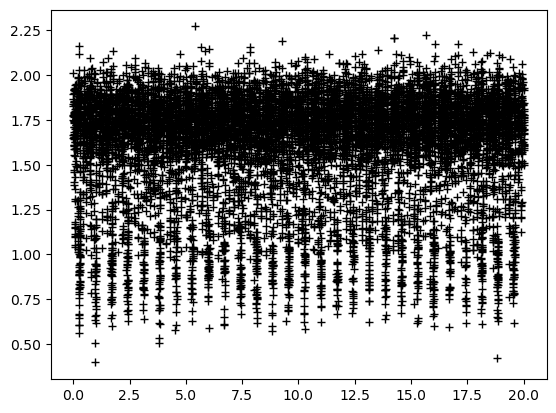

In [9]:
###Plot check of photon cloud
goodpts_plt =  np.where( (ph_confidence >= min_photon_confidence_flag ) & (ph_lat > 71.32) & (ph_lat < 71.33 ))
plt.plot(ph_track_dist[goodpts_plt]-np.min(ph_track_dist[goodpts_plt]),ph_height[goodpts_plt],'+k')	
plt.show()

/home/jovyan/Nathan_surfit/is2_model.py:66: RuntimeWarning: invalid value encountered in log
  surf_pdf = 1/(xgtau*sig_surf*np.sqrt(2*pi)) * np.exp( -1.0*(np.log(xgtau) - mu)**2 / (2*sig_surf**2))  ##log-normal function distribution


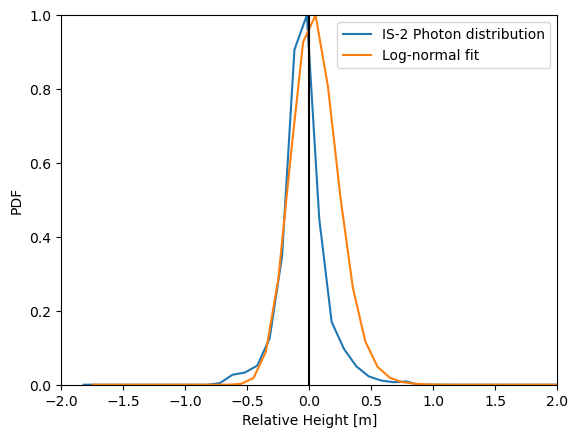

N photons, retrack elev, lognormal sigma:  4425 0.07011911259223955 0.11444601627982659


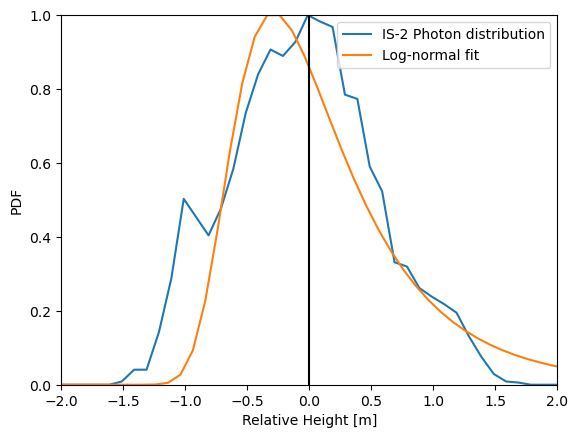

N photons, retrack elev, lognormal sigma:  5049 -0.027203914703088545 0.5814558643672219


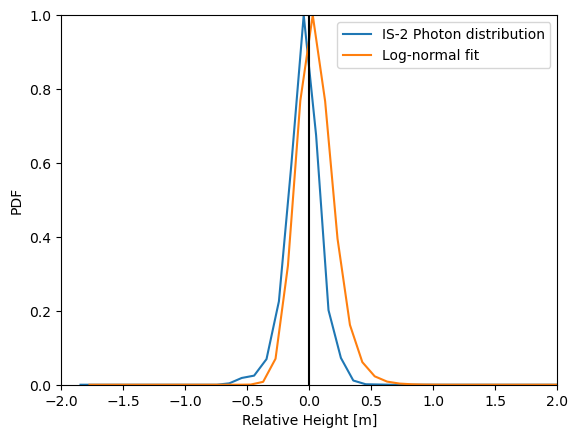

N photons, retrack elev, lognormal sigma:  4599 0.07279186568553328 0.005700648821132389


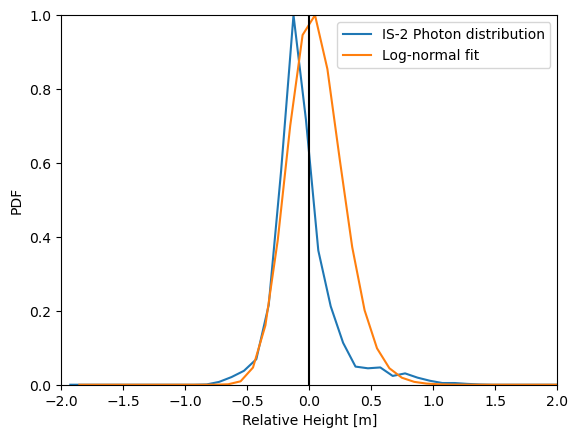

N photons, retrack elev, lognormal sigma:  4663 0.07332488837357334 0.15744556727795495


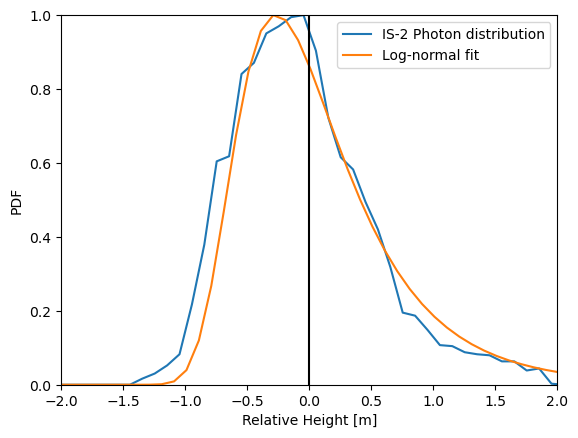

N photons, retrack elev, lognormal sigma:  4691 0.05613215173360844 0.5306126401839204


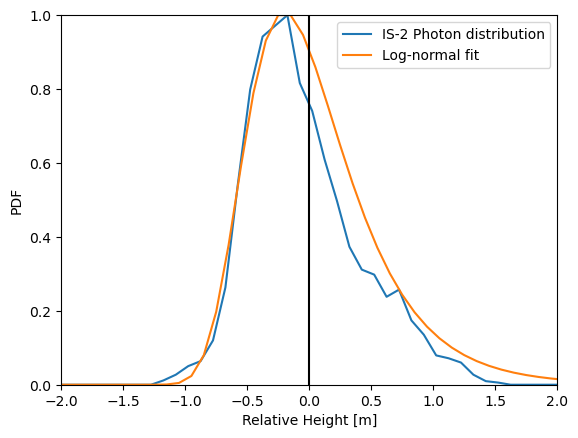

N photons, retrack elev, lognormal sigma:  4908 0.025878576630783384 0.44557009899240657


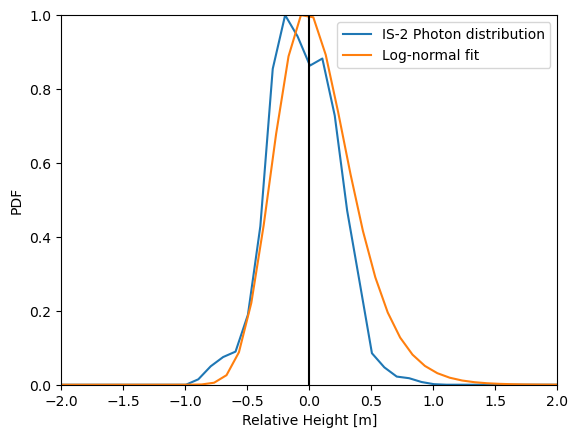

N photons, retrack elev, lognormal sigma:  4801 0.027314721935652958 0.2720988230158854


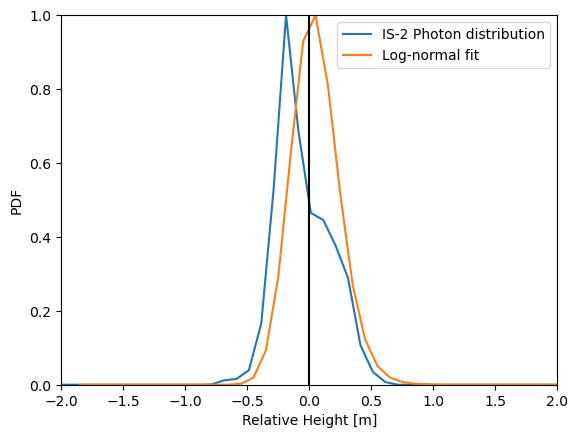

N photons, retrack elev, lognormal sigma:  4570 0.13768727701559155 0.11692635136674098


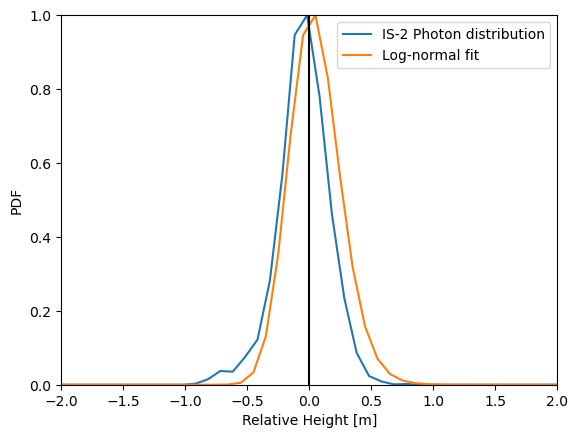

N photons, retrack elev, lognormal sigma:  4793 0.06746339974364514 0.1381248563619255


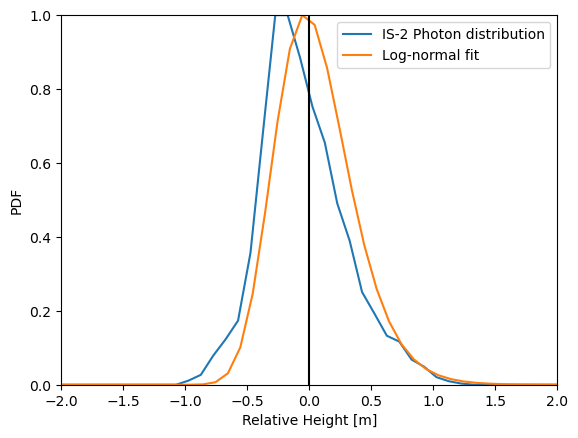

N photons, retrack elev, lognormal sigma:  4732 0.11795758898062327 0.2668921800283892


In [10]:
##For each segment fit the surface height distribution and plot

min_dtime = ph_delta_time[0]
for ngood in range(0,10):  #npts-1
    
    max_dtime = min_dtime + segment_length/6900.0  #Assumes a constant orbital speed and converted to length of segment

    init_ph_loc = np.where( (ph_delta_time >= min_dtime) & (ph_delta_time < max_dtime) )
    coarse_ph_mean = np.mean(ph_height[init_ph_loc])
    photons_loc = np.where( (ph_delta_time >= min_dtime) & (ph_delta_time < max_dtime) & ( ph_height > (ph_height-window_size) ) & ( ph_height < (ph_height+window_size)) )
    ph_mean = np.mean(ph_height[photons_loc])
    ph_std = np.std(ph_height[photons_loc])
    
    #plt.plot(ph_delta_time[photons_loc],ph_height[photons_loc]-ph_mean,'+k')
    #plt.show()
    
    
    nrb = 70
    rb_res = 0.1
    track_point = ph_mean
    range_bins_m = np.arange(1, nrb) * rb_res - (nrb-1)/2*rb_res - ph_mean #(nrb-1)/3*rb_res  # Set range bins with 3 cm resolution
    wf = np.histogram(ph_height[photons_loc]-ph_mean,bins=range_bins_m)
    WF_norm_this = wf[0][:]/np.max(wf[0][:])
    wf_rb = wf[1][:]
    
    
    # Calculate lognormal fit

    range_bins_m_hr = np.arange(1, nrb*5) * rb_res/5 - (5*nrb-1)/2*rb_res/5 - ph_mean  # Set range bins with 5x rb_res cm resolution for use when generating pulse shape and distributions
    range_bins_unit = np.arange(1, nrb)

    tracker = lambda xdata, *p: is2m.is2modelfit(xdata, p,range_bins_m_hr)

    rb_use = range_bins_m[0:np.size(WF_norm_this)]
    x0 = np.asarray([1.0, 0, ph_std])  # y scale factor, x shift (in meters), roughness
    lb = x0 - [0.05, 0.5, 0.3]
    ub = x0 + [0.05, 0.5, 0.3]
    if lb[2] < 0:
        lb[2] = 0.005
    GSFC_optimal, GSFC_cov = curve_fit(tracker, rb_use, WF_norm_this, x0, bounds=(lb, ub), method='trf',  **fit_opts)


    GSFC_fit = is2m.is2modelfit(rb_use, GSFC_optimal,range_bins_m_hr)
    # Calculate sum of squared residuals
    GSFC_resnorm = np.sum((WF_norm_this - GSFC_fit)**2)
    
    
    #dual_Gaussian_fit = weight1*1/(np.sqrt(2*np.pi)*w1) * np.exp(-0.5*(xin-m1)**2/(w1)**2) + weight2*1/(np.sqrt(2*np.pi)*w2) * np.exp(-0.5*(xin-m2)**2/(w2)**2)
    #dual_Gaussian_fit = dual_Gaussian_fit/np.max(dual_Gaussian_fit)
    #surf_pdf = dual_Gaussian_fit
    ####Generate IS-2 transmit pulse shape and convolve with Gaussian
    #mu = 0.0
    #sigma = 0.116767  #sigma of Gaussian in meters  
    #tau = 9.92750  #exponential relaxation time in meters
    #xin = wf_rb[0:np.size(wf[0][:])]
    #taufit_hr = xin
    #taufit = xin
    ##Convert range bin times to x values in meters with mean of x at tau=0
    #mean_xmg = mu + 1/tau
    #xmgtau = taufit_hr + mean_xmg
    #yy = tau/2*np.exp(tau/2*(2*mu + tau*sigma**2 - 2*xmgtau))*scipy.special.erfc( (mu + tau*sigma**2 - xmgtau) / (np.sqrt(2)*sigma) )

    
    #power = np.convolve(surf_pdf,yy)
    ## Change axis size after convolution
    #Taxis=np.arange(0,len(power))*(taufit[1]-taufit[0]) + taufit[0]*2

    ##  Get convolved power matrix to same size as input
    #startloc = np.argmin(np.abs(Taxis - taufit[0])) # finds location of taufit start on Taxis
    #power_final = power[startloc:startloc+len(taufit)]

    ##  normalize, remove negative values
    #power_final = power_final/np.max(power_final)
    #power_final[power_final < 0] = 0
    #dual_Gaussian_fit = power_final / np.max(power_final)
    #####################################
    
    p1b,=plt.plot(wf_rb[0:np.size(wf[0][:])],WF_norm_this,label='IS-2 Photon distribution')
    #p1w,=plt.plot(wf_rb[0:np.size(wf[0][:])],dual_Gaussian_fit,label='Dual Gaussian fit')
    #p2 = plt.plot([track_point,0],[track_point,1],'k')
    p1a,=plt.plot(rb_use+GSFC_optimal[1]-0*range_bins_m_hr[0],GSFC_fit/np.max(GSFC_fit),label='Log-normal fit')
    #p2=plt.plot(rb_use+GSFC_optimal[1],WF_norm_this,'k')
    p2 = plt.plot([0,0],[0,1],'k') #Plot 0 point which is the mean height location
    #p1 = plt.plot([1.0*GSFC_optimal[1],1.0*GSFC_optimal[1]],[0,1])  #Plot Ron's ATL07 tracking point
    plt.legend(handles=[p1b, p1a])
    plt.axis([-2, 2, 0, 1]) 
    plt.xlabel('Relative Height [m]')
    plt.ylabel('PDF')
    plt.show()
    
    print("N photons, retrack elev, lognormal sigma: ",np.size(photons_loc),GSFC_optimal[1],GSFC_optimal[2])

       
    #pdb.set_trace()
    
    min_dtime = max_dtime #Move segment forward